In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
file_path = "/kaggle/input/ptb-diagnostic-ecg-dataset/train_meta.csv" 
train_meta = pd.read_csv(file_path)
train_meta

,ecg_id,age,sex,height,weight,NORM,MI,STTC,HYP,CD
0,1,56.0,1,NaN,63.0,1,0,0,0,0
1,2,19.0,0,NaN,70.0,1,0,0,0,0
2,3,37.0,1,NaN,69.0,1,0,0,0,0
3,4,24.0,0,NaN,82.0,1,0,0,0,0
4,5,19.0,1,NaN,70.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,0,0,0,0,1
17437,21833,67.0,1,NaN,NaN,0,0,1,0,0
17438,21834,93.0,0,NaN,NaN,1,0,0,0,0
17439,21835,59.0,1,NaN,NaN,0,0,1,0,0


In [3]:
file_path = "/kaggle/input/ptb-diagnostic-ecg-dataset/train_signal.csv" 
train_signal = pd.read_csv(file_path)
train_signal

,ecg_id,channel-0,channel-1,channel-3
0,1,-0.119,-0.055,0.086
1,1,-0.116,-0.051,0.083
2,1,-0.120,-0.044,0.082
3,1,-0.117,-0.038,0.077
4,1,-0.103,-0.031,0.066
...,...,...,...,...
17440995,21836,0.096,0.189,-0.143
17440996,21836,0.051,0.119,-0.085
17440997,21836,0.033,0.070,-0.052
17440998,21836,0.027,0.082,-0.055


In [4]:
hyp_ids = train_meta[train_meta['HYP'] == 1]['ecg_id']
train_signal = train_signal[~train_signal['ecg_id'].isin(hyp_ids)]
train_meta = train_meta.drop(columns=['HYP'])
train_meta = train_meta[~train_meta['ecg_id'].isin(hyp_ids)]

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# ---------------------------
# Data Loading and Preprocessing for Training Data
# ---------------------------

# Extract class labels
label_cols = ['NORM', 'MI', 'STTC', 'CD']
if 'target' not in train_meta.columns:
    train_meta['target'] = train_meta[label_cols].values.argmax(axis=1)

# Prepare training data
X_train, y_train = [], []
grouped = train_signal.groupby('ecg_id')
for ecg_id, group in grouped:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_train.append(sample)
    
    label = train_meta.loc[train_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_train.append(label[0])

X_train = np.array(X_train)  # Shape: (num_train_samples, 1000, 3)
y_train = np.array(y_train)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (15320, 1000, 3)
Training labels shape: (15320,)


In [6]:
# ---------------------------
# Data Loading and Preprocessing for Validation Data
# ---------------------------
val_meta = pd.read_csv('/kaggle/input/ptb-diagnostic-ecg-dataset/valid_meta.csv')
val_signal = pd.read_csv('/kaggle/input/ptb-diagnostic-ecg-dataset/valid_signal.csv')

hyp_ids = val_meta[val_meta['HYP'] == 1]['ecg_id']
val_signal = val_signal[~val_signal['ecg_id'].isin(hyp_ids)]
val_meta = val_meta.drop(columns=['HYP'])
val_meta = val_meta[~val_meta['ecg_id'].isin(hyp_ids)]

if 'target' not in val_meta.columns:
    val_meta['target'] = val_meta[label_cols].values.argmax(axis=1)

X_val, y_val = [], []
grouped_val = val_signal.groupby('ecg_id')
for ecg_id, group in grouped_val:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_val.append(sample)
    
    label = val_meta.loc[val_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_val.append(label[0])

X_val = np.array(X_val)  # Shape: (num_val_samples, 1000, 3)
y_val = np.array(y_val)

print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)


Validation data shape: (1922, 1000, 3)
Validation labels shape: (1922,)


In [7]:
# ---------------------------
# Normalize the Signals
# ---------------------------
scaler = StandardScaler()

# Reshape and scale training data
X_train_reshaped = X_train.reshape(-1, 3)
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(X_train.shape)

# Reshape and scale validation data
X_val_reshaped = X_val.reshape(-1, 3)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(X_val.shape)

In [8]:
# ---------------------------
# Convert Labels to One-Hot Encoding
# ---------------------------
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

In [9]:
# ---------------------------
# Build an LSTM Model
# ---------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1000, 3)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(128),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1000, 64)            │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1000, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,524 (1.20 MB)

 Trainable params: 314,884 (1.20 MB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
# ---------------------------
# Train the Model
# ---------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 30
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train_cat, 
    validation_data=(X_val, y_val_cat),
    epochs=30, 
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step - accuracy: 0.4437 - loss: 1.3806 - val_accuracy: 0.5146 - val_loss: 1.1932
Epoch 2/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.5323 - loss: 1.1710 - val_accuracy: 0.5624 - val_loss: 1.1056
Epoch 3/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.5623 - loss: 1.1046 - val_accuracy: 0.6046 - val_loss: 1.0114
Epoch 4/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.5991 - loss: 1.0486 - val_accuracy: 0.5016 - val_loss: 1.2260
Epoch 5/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.5824 - loss: 1.0679 - val_accuracy: 0.5952 - val_loss: 1.0370
Epoch 6/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.6149 - loss: 1.0078 - val_accuracy: 0.5931 - val_loss: 1.0083
Epoch 7/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.6004 - loss: 1.0322 - val_accuracy: 0.6223 - val_loss: 0.9520
Epoch 8/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.6258 - loss: 0.9599 - 

In [11]:
# ---------------------------
# Evaluate Using F1 Score
# ---------------------------
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Validation F1 Score:", f1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Validation F1 Score: 0.7171335629627705


In [12]:
# ---------------------------
# Evaluation on Test Data
# ---------------------------
# Load test datasets
test_meta = pd.read_csv('/kaggle/input/ptb-diagnostic-ecg-dataset/test_meta.csv')
test_signal = pd.read_csv('/kaggle/input/ptb-diagnostic-ecg-dataset/test_signal.csv')

hyp_ids = test_meta[test_meta['HYP'] == 1]['ecg_id']
test_signal = test_signal[~test_signal['ecg_id'].isin(hyp_ids)]
test_meta = test_meta.drop(columns=['HYP'])
test_meta = test_meta[~test_meta['ecg_id'].isin(hyp_ids)]

# Process test signal data similarly to training data.
grouped_test = test_signal.groupby('ecg_id')
X_test = []
y_test = []

for ecg_id, group in grouped_test:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_test.append(sample)
    
    # Retrieve label from test_meta; assuming same logic for 'target'
    if 'target' not in test_meta.columns:
        label_cols = ['NORM', 'MI', 'STTC', 'CD']
        test_meta['target'] = test_meta[label_cols].values.argmax(axis=1)
    label = test_meta.loc[test_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_test.append(label[0])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Test data shape: (1940, 1000, 3)
Test labels shape: (1940,)


In [13]:
# Normalize test data using the same scaler as training data.
nsamples_test, nsteps_test, nchannels_test = X_test.shape
X_test_reshaped = X_test.reshape(-1, nchannels_test)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(nsamples_test, nsteps_test, nchannels_test)

y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size)
print("Test Accuracy:", test_acc)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7313 - loss: 0.7132
Test Accuracy: 0.7319587469100952


In [14]:
# Predict on the Test data
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test F1 Score:", f1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Test F1 Score: 0.7161542666689883


In [15]:
import numpy as np

# Get unique class labels
classes = np.unique(y_test)

# Compute per-class accuracy
class_accuracies = {}
for c in classes:
    actual_c = (y_test == c)  # Indices where actual class is c
    correct_c = np.sum(y_test_pred[actual_c] == c)  # Correctly predicted c
    total_c = np.sum(actual_c)  # Total actual occurrences of c
    class_accuracies[c] = correct_c / total_c if total_c > 0 else 0

# Print results
for c, acc in class_accuracies.items():
    print(f"Accuracy for class {c}: {acc:.4f}")

Accuracy for class 0: 0.9411
Accuracy for class 1: 0.5497
Accuracy for class 2: 0.4982
Accuracy for class 3: 0.4185


In [16]:
# Records | Superclass | Description
# 9528 | NORM | Normal ECG
# 5486 | MI | Myocardial Infarction
# 5250 | STTC | ST/T Change
# 4907 | CD | Conduction Disturbance

In [17]:
# Save the model
model.save("disease_detection_lstm_model.h5")

# Model to Detect only Abnormality or Not

In [18]:
train_meta['target'] = train_meta['target'].apply(lambda x: 1 if x != 0 else 0)
train_meta = train_meta.drop(columns=['NORM', 'MI', 'STTC', 'CD'])

In [19]:
val_meta['target'] = val_meta['target'].apply(lambda x: 1 if x != 0 else 0)
val_meta = val_meta.drop(columns=['NORM', 'MI', 'STTC', 'CD'])

In [20]:
# Prepare training data
X_train, y_train = [], []
grouped = train_signal.groupby('ecg_id')
for ecg_id, group in grouped:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_train.append(sample)
    
    label = train_meta.loc[train_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_train.append(label[0])

X_train = np.array(X_train)  # Shape: (num_train_samples, 1000, 3)
y_train = np.array(y_train)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (15320, 1000, 3)
Training labels shape: (15320,)


In [21]:
X_val, y_val = [], []
grouped_val = val_signal.groupby('ecg_id')
for ecg_id, group in grouped_val:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_val.append(sample)
    
    label = val_meta.loc[val_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_val.append(label[0])

X_val = np.array(X_val)  # Shape: (num_val_samples, 1000, 3)
y_val = np.array(y_val)

print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

Validation data shape: (1922, 1000, 3)
Validation labels shape: (1922,)


In [22]:
# ---------------------------
# Convert Labels to One-Hot Encoding
# ---------------------------
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

In [23]:
# ---------------------------
# Build an LSTM Model
# ---------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1000, 3)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(128),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 1000, 64)            │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1000, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,266 (1.20 MB)

 Trainable params: 314,626 (1.20 MB)

 Non-trainable params: 640 (2.50 KB)

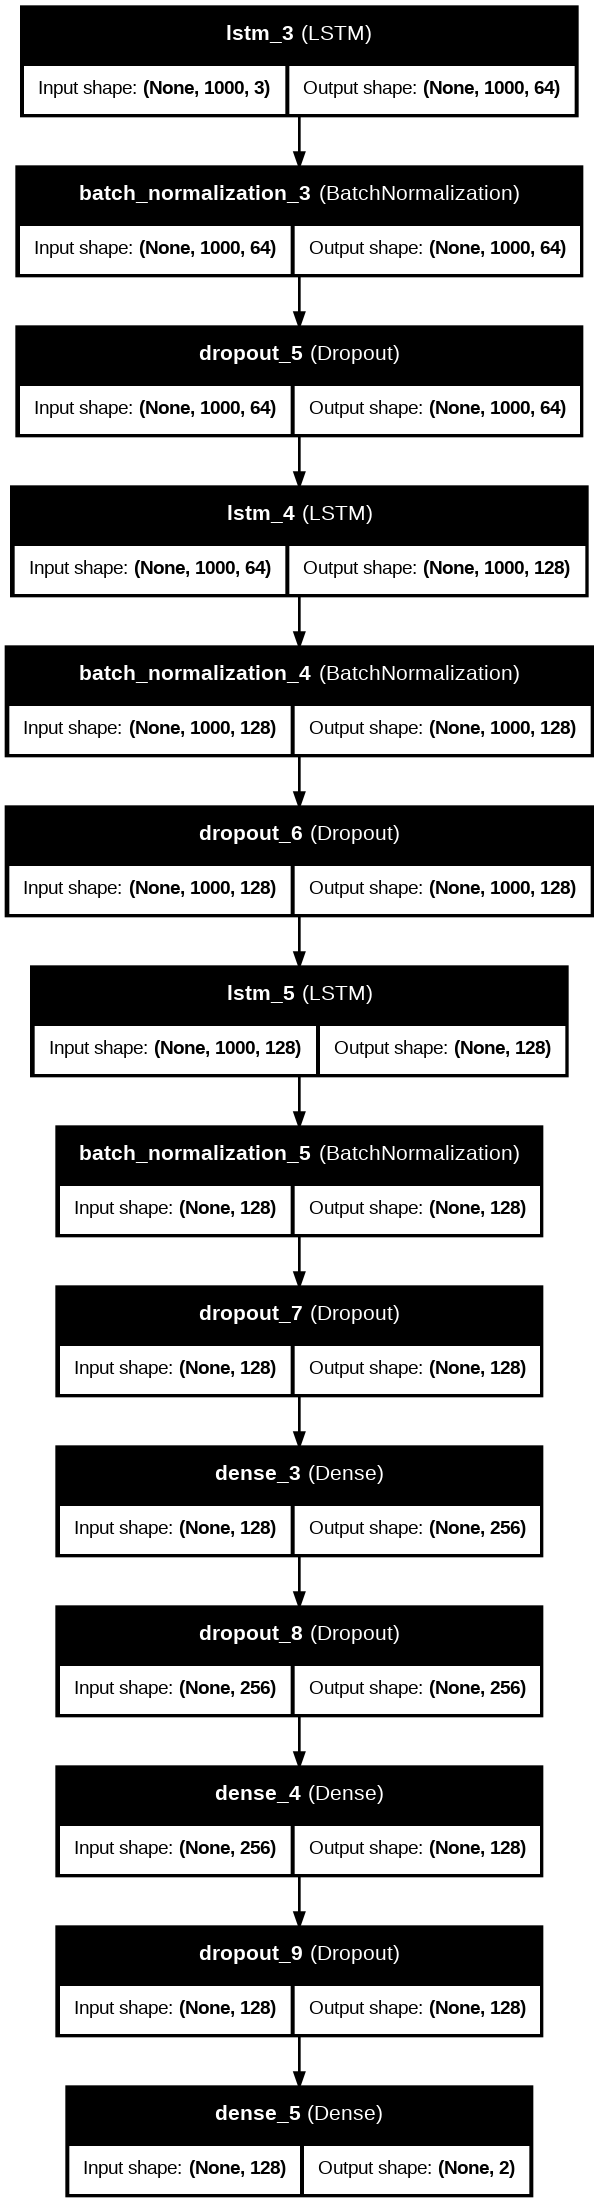

In [24]:
from tensorflow.keras.utils import plot_model

# Save and display the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)

In [25]:
# ---------------------------
# Train the Model
# ---------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 30
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train_cat, 
    validation_data=(X_val, y_val_cat),
    epochs=30, 
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.5151 - loss: 0.8301 - val_accuracy: 0.5260 - val_loss: 0.6927
Epoch 2/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.5773 - loss: 0.6792 - val_accuracy: 0.6191 - val_loss: 0.6696
Epoch 3/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.6418 - loss: 0.6483 - val_accuracy: 0.5359 - val_loss: 0.7017
Epoch 4/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.6200 - loss: 0.6491 - val_accuracy: 0.6400 - val_loss: 0.6390
Epoch 5/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.6074 - loss: 0.6600 - val_accuracy: 0.5869 - val_loss: 0.6741
Epoch 6/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.6298 - loss: 0.6448 - val_accuracy: 0.5177 - val_loss: 0.7232
Epoch 7/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.6466 - loss: 0.6399 - val_accuracy: 0.4880 - val_loss: 0.6986
Epoch 8/30
479/479 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.5108 - loss: 0.6948 - 

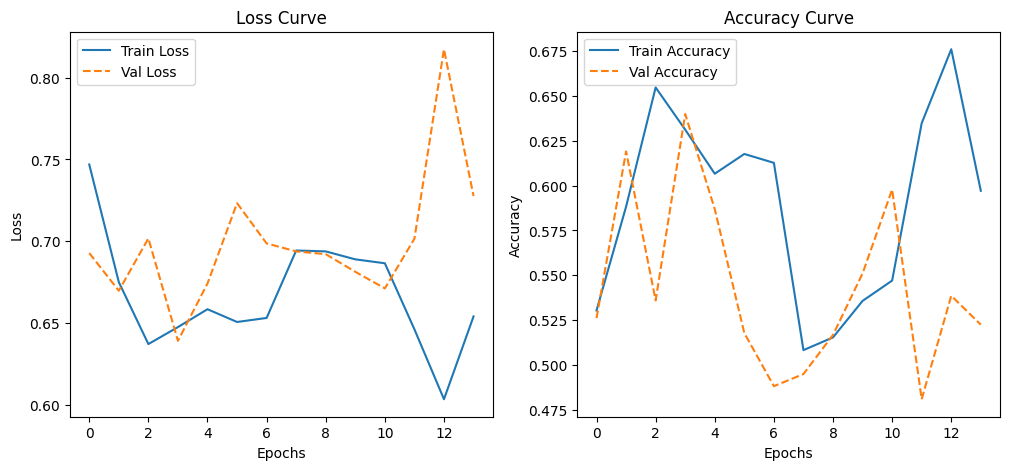

In [26]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [27]:
# ---------------------------
# Evaluate Using F1 Score
# ---------------------------
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Validation F1 Score:", f1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Validation F1 Score: 0.6365912167355585


In [28]:
test_meta['target'] = test_meta['target'].apply(lambda x: 1 if x != 0 else 0)
test_meta = test_meta.drop(columns=['NORM', 'MI', 'STTC', 'CD'])

In [29]:
grouped_test = test_signal.groupby('ecg_id')
X_test = []
y_test = []

for ecg_id, group in grouped_test:
    if len(group) != 1000:
        continue
    sample = group[['channel-0', 'channel-1', 'channel-3']].to_numpy()
    X_test.append(sample)
    
    label = test_meta.loc[test_meta['ecg_id'] == ecg_id, 'target'].values
    if len(label) == 0:
        continue
    y_test.append(label[0])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Test data shape: (1940, 1000, 3)
Test labels shape: (1940,)


In [30]:
# Predict on the Test data
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test F1 Score:", f1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Test F1 Score: 0.6328872121455925


In [31]:
import numpy as np

# Get unique class labels
classes = np.unique(y_test)

# Compute per-class accuracy
class_accuracies = {}
for c in classes:
    actual_c = (y_test == c)  # Indices where actual class is c
    correct_c = np.sum(y_test_pred[actual_c] == c)  # Correctly predicted c
    total_c = np.sum(actual_c)  # Total actual occurrences of c
    class_accuracies[c] = correct_c / total_c if total_c > 0 else 0

# Print results
for c, acc in class_accuracies.items():
    print(f"Accuracy for class {c}: {acc:.4f}")

Accuracy for class 0: 0.5469
Accuracy for class 1: 0.7303


In [32]:
# Save the model
model.save("anomaly_detection_lstm_model.h5")